Unzipping the dataset

In [ ]:
!unzip archive.zip

Importing Libraries

In [ ]:
import cv2
import numpy as np
import pandas as pd
import random
import glob
import csv
import keras
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
def tiles_images(img, pieces):
  img_width = img_height = img.shape[1] // pieces

  tiles_img = [img[x:x+img_height,y:y+img_width] 
             for x in range(0,img.shape[0], img_height) 
             for y in range(0,img.shape[1],img_width)
            ]

  new_tiles = []

  for img in tiles_img:
    if img.shape[0] == img_width and  img.shape[1] == img_height:
      new_tiles.append(img)

  return new_tiles

In [ ]:
def group_images(images, shuffle_arr, pieces=2):
  new_img = []

  shuffle_tiles =  [images[i] for i in shuffle_arr]

  for i in range(pieces):
    new_img.append(np.concatenate(shuffle_tiles[i*pieces:(i+1)*pieces], axis=1))
    
  new_img = np.concatenate(new_img, axis=0)
  return new_img

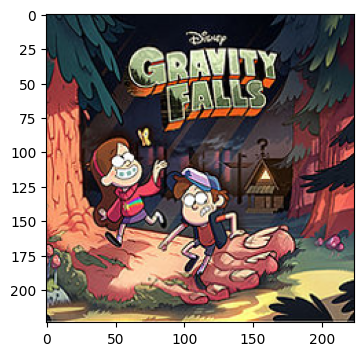

In [ ]:
image = cv2.imread('/content/Gravity Falls/correct/0.png') 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.subplots(figsize=(4,4))
plt.imshow(image)

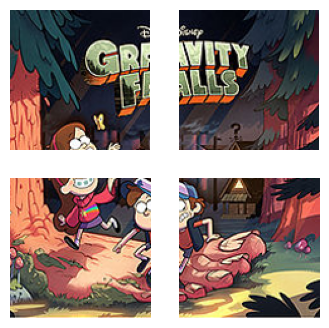

In [ ]:
pieces = 2     # number pieces in one row/column 
tiles = tiles_images(image, pieces)

fig, ax = plt.subplots(pieces, pieces, figsize=(4, 4))

for i, idx in enumerate(range(pieces**2)):
  plt.subplot(pieces, pieces, i+1)
  plt.imshow(tiles[idx])
  plt.axis("off")

In [ ]:
shuffle_arr = np.random.permutation(len(tiles))

In [ ]:
shuffle_arr

array([1, 2, 0, 3])

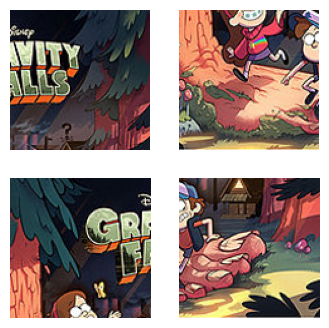

In [ ]:
fig, ax = plt.subplots(pieces, pieces, figsize=(4, 4))

for i, idx in enumerate(shuffle_arr):
  plt.subplot(pieces, pieces, i+1)
  plt.imshow(tiles[idx])
  plt.axis("off")

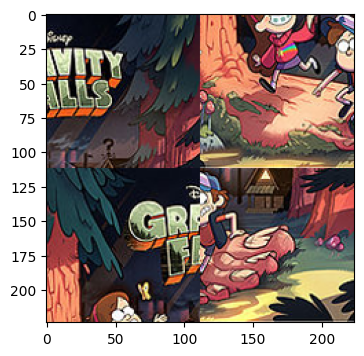

In [ ]:
shuffle_img = group_images(tiles, shuffle_arr)

plt.subplots(figsize=(4, 4))
plt.imshow(shuffle_img)

In [ ]:
correct_image_path = "/content/Gravity Falls/correct/*"
correct_image = [cv2.imread(file) for file in glob.glob(correct_image_path)]

In [ ]:
X, Y = [], []
pieces = 8   # number pieces in one row/column

data_type = 'train'            #change for test, train and validation data
X_path = "puzzle_8x8/"+data_type+"/"

!mkdir puzzle_8x8             #create directory
!mkdir {X_path}

n = 10 if data_type=='train' else 1        #for train dataset create 10x images

for j in range(n):
  for i, img in enumerate(correct_image):
    tiles = tiles_images(img, pieces)

    array = np.random.permutation(len(tiles))
    Y.append(array)

    group_img = group_images(tiles, array, pieces)
    X.append(group_img)

    path = f"{X_path}{i+j*110}.jpg"
    cv2.imwrite(path, group_img)
    
with open("puzzle_8x8/"+data_type+'.csv', 'w') as file:
  writer = csv.writer(file)
  head = [i for i in range(pieces**2)]
  writer.writerow(head)
  writer.writerows(Y)

In [ ]:
import cv2
import numpy as np
import pandas as pd
import random
import glob
import csv
import keras
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
def tiles_images(img, pieces):
    img_width = img_height = img.shape[1] // pieces
    tiles_img = [img[x:x+img_height,y:y+img_width]
                 for x in range(0,img.shape[0], img_height)
                 for y in range(0,img.shape[1],img_width)
                ]
    
    new_tiles = []
    
    for img in tiles_img:
        if img.shape[0] == img_width and  img.shape[1] == img_height:
            new_tiles.append(img)

    return new_tiles

In [ ]:
def group_image(images, shuffle_arr, pieces=2):
    img = []
    
    new_array = [shuffle_arr[i] for i in shuffle_arr]
    print(new_array)
    new_order =  [images[i] for i in new_array]
    
    for i in range(pieces):
        img.append(np.concatenate(new_order[i*pieces:(i+1)*pieces], axis=1))
    
    img = np.concatenate(img, axis=0)
    return img

In [ ]:
def load_data(base_path, path, pieces=2):
    data = pd.read_csv(base_path + '{}.csv'.format(path))
    path = base_path + path + '/'

    x, y = [], []
    for i in range(len(data)):
        im = Image.open(path + str(i) + '.jpg')
        im = np.array(im).astype('float16')
        im = im / 255 - 0.5
        
        if path.split('/')[-2] == 'test':
            x.append(im)
        else:
            x.append(tiles_images(im, pieces))

        label = data.iloc[i]
        label = [int(i) for i in label]
        y.append(label)

    return (np.array(x), np.expand_dims(np.array(y), axis=-1))

In [ ]:
base_path = "/content/Gravity Falls/puzzle_2x2"

In [ ]:
x_train, y_train = load_data(base_path, '/train')

In [ ]:
x_val, y_val = load_data(base_path, '/valid')

In [ ]:
x_test, y_test = load_data(base_path, '/test')

In [ ]:
import keras
from keras.layers import TimeDistributed as td
from keras.layers import Conv2D, Flatten, Dense, ZeroPadding2D, Activation
from keras.layers import MaxPooling2D, Dropout, BatchNormalization, Reshape

In [ ]:
def get_model():

    model = keras.models.Sequential()

    model.add(td(ZeroPadding2D(2), input_shape=(4, 112, 112, 3)))

    model.add(td(Conv2D(50, kernel_size=(5,5), padding='same', activation='relu', strides=2)))
    model.add(td(BatchNormalization()))
    model.add(td(MaxPooling2D()))

    model.add(td(Conv2D(100, kernel_size=(5,5), padding='same', activation='relu', strides=2)))
    model.add(td(BatchNormalization()))
    model.add(td(Dropout(0.3)))

    model.add(td(Conv2D(100, kernel_size=(3,3), padding='same', activation='relu', strides=2)))
    model.add(td(BatchNormalization()))
    model.add(td(Dropout(0.3)))

    model.add(td(Conv2D(200, kernel_size=(3,3), padding='same', activation='relu', strides=1)))
    model.add(td(BatchNormalization()))
    model.add(td(Dropout(0.3)))

    model.add(Flatten())

    model.add(Dense(600, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(400, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(16))
    model.add(Reshape((4, 4)))
    model.add(Activation('softmax'))

    return model

In [ ]:
model = get_model()

In [ ]:
adam = keras.optimizers.Adam(learning_rate=.001)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy',
              metrics = ['sparse_categorical_accuracy'])

In [ ]:
x_train.shape

(440, 4, 112, 112, 3)

In [ ]:
y_train.shape

(440, 4, 1)

In [ ]:
model.fit(x_train, y_train, batch_size=16, epochs=25, validation_data=(x_val, y_val))

Epoch 1/25
28/28 [==============================] - 41s 1s/step - loss: 0.1291 - sparse_categorical_accuracy: 0.9540 - val_loss: 5.0974 - val_sparse_categorical_accuracy: 0.2886
Epoch 2/25
28/28 [==============================] - 41s 1s/step - loss: 0.8010 - sparse_categorical_accuracy: 0.7506 - val_loss: 4.3695 - val_sparse_categorical_accuracy: 0.3227
Epoch 3/25
28/28 [==============================] - 41s 1s/step - loss: 0.7096 - sparse_categorical_accuracy: 0.7614 - val_loss: 1.8668 - val_sparse_categorical_accuracy: 0.5182
Epoch 4/25
28/28 [==============================] - 44s 2s/step - loss: 0.2870 - sparse_categorical_accuracy: 0.8966 - val_loss: 1.9096 - val_sparse_categorical_accuracy: 0.4955
Epoch 5/25
28/28 [==============================] - 40s 1s/step - loss: 0.2149 - sparse_categorical_accuracy: 0.9256 - val_loss: 1.3105 - val_sparse_categorical_accuracy: 0.6068
Epoch 6/25
28/28 [==============================] - 41s 1s/step - loss: 0.1232 - sparse_categorical_accuracy: 

1/1 [==============================] - 0s 83ms/step
y_pred =  [3 1 0 2]


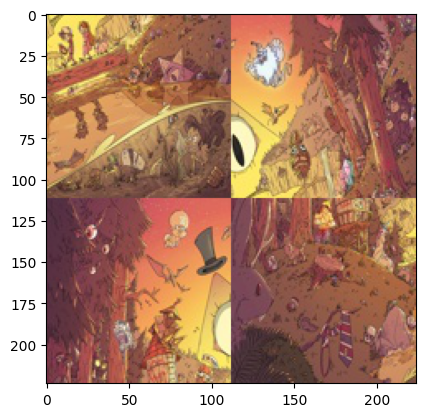

In [ ]:
i = 2      #for i-th example in test data
image = x_test[i].astype('float64')+.5
plt.imshow(image)

inp = np.expand_dims(tiles_images(x_test[i], pieces=2), axis=0)
y_pred = model.predict(inp)[0]
y_pred = np.argmax(y_pred, axis=1)
print('y_pred = ',y_pred)

[2, 1, 3, 0]


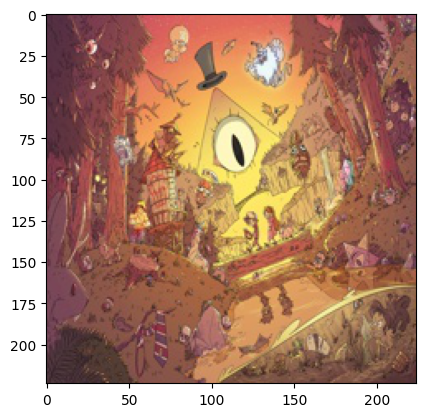

In [ ]:
tiles = tiles_images(image, pieces=2)
predit_img = group_image(tiles, y_pred, pieces=2)
plt.imshow(predit_img)

1/1 [==============================] - 0s 150ms/step
y_pred =  [0 2 3 1]


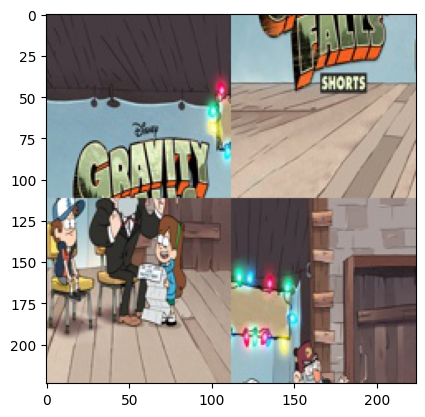

In [ ]:
i = 45   #for i-th example in test data
image = x_test[i].astype('float64')+.5
plt.imshow(image)

inp = np.expand_dims(tiles_images(x_test[i], pieces=2), axis=0)
y_pred = model.predict(inp)[0]
y_pred = np.argmax(y_pred, axis=1)
print('y_pred = ',y_pred)

[0, 3, 1, 2]


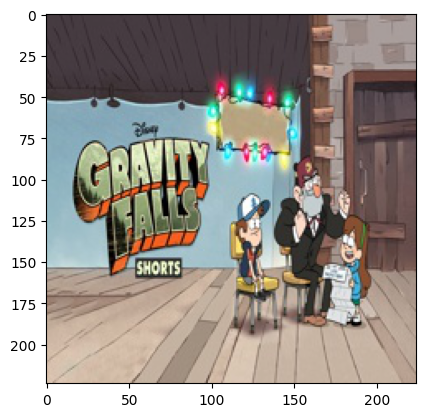

In [ ]:
tiles = tiles_images(image, pieces=2)
predit_img = group_image(tiles, y_pred, pieces=2)
plt.imshow(predit_img)

In [ ]:
model.save('model.h5')